In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import joblib  # For saving sklearn models


In [80]:
FILE_PATH = "rupiah_classification.csv"

In [81]:
# Load and preprocess dataset
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)

    X = data.iloc[:, 2:].values  # All features except image_name and nominal_label
    y = data['nominal_label'].values

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    # Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y, label_encoder

In [82]:
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [83]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [84]:
# Perform cross-validation
def perform_cross_validation(model, X, y, model_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {np.mean(scores):.4f} \u00b1 {np.std(scores):.4f}")

In [85]:
def train_random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Random Forest Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save the model
    joblib.dump(model, 'random_forest_model.pkl')
    print("Random Forest model saved as 'random_forest_model.pkl'")    # Perform cross-validation
    perform_cross_validation(model, X_train, y_train, "Random Forest")

In [86]:
def train_svm(X_train, y_train, X_test, y_test):
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("SVM Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save the model
    joblib.dump(model, 'svm_model.pkl')
    print("SVM model saved as 'svm_model.pkl'")    # Perform cross-validation
    perform_cross_validation(model, X_train, y_train, "SVM")

In [87]:
def build_and_train_fcnn(X_train, y_train, X_test, y_test, label_encoder):
    input_dim = X_train.shape[1]
    num_classes = len(label_encoder.classes_)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,),
                              kernel_regularizer=l2(1e-4)),  # L2 Regularization
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=300,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Save the model
    model.save('fcnn_model.h5')
    print("Fully Connected Neural Network model saved as 'fcnn_model.h5'")

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print("Improved FCNN Classification Report:")
    print(classification_report(y_test, y_pred))

In [88]:
X, y, label_encoder = load_and_preprocess_data(FILE_PATH)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
print("Training Random Forest...")
train_random_forest(X_train, y_train, X_test, y_test)

Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.46      0.53        28
           1       0.58      0.71      0.64        21
           2       0.32      0.35      0.33        20
           3       0.96      0.96      0.96        24
           4       0.56      0.58      0.57        26
           5       1.00      0.97      0.98        29
           6       1.00      1.00      1.00        32

    accuracy                           0.74       180
   macro avg       0.72      0.72      0.72       180
weighted avg       0.75      0.74      0.74       180

Random Forest model saved as 'random_forest_model.pkl'
Random Forest Cross-Validation Accuracy: 0.6926 ± 0.0458


In [90]:
print("Training SVM...")
train_svm(X_train, y_train, X_test, y_test)

Training SVM...
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.39      0.42        28
           1       0.46      0.62      0.53        21
           2       0.35      0.45      0.39        20
           3       0.92      1.00      0.96        24
           4       0.56      0.35      0.43        26
           5       1.00      0.93      0.96        29
           6       0.88      0.91      0.89        32

    accuracy                           0.68       180
   macro avg       0.66      0.66      0.66       180
weighted avg       0.69      0.68      0.68       180

SVM model saved as 'svm_model.pkl'
SVM Cross-Validation Accuracy: 0.5894 ± 0.0340


Training Fully Connected Neural Network...
Epoch 1/300


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1785 - loss: 2.4506 - val_accuracy: 0.2944 - val_loss: 1.8002 - learning_rate: 0.0010
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2588 - loss: 2.1683 - val_accuracy: 0.3333 - val_loss: 1.7158 - learning_rate: 0.0010
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3020 - loss: 1.8639 - val_accuracy: 0.4222 - val_loss: 1.6434 - learning_rate: 0.0010
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3322 - loss: 1.7768 - val_accuracy: 0.4500 - val_loss: 1.5813 - learning_rate: 0.0010
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3738 - loss: 1.6891 - val_accuracy: 0.4778 - val_loss: 1.5202 - learning_rate: 0.0010
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4091 - loss: 1.5373 - val_accuracy: 0.5111 - val_loss: 1.4635 - learning_rate: 0.0010
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4469 - loss: 1.4505 - val_accuracy: 0.52

Fully Connected Neural Network model saved as 'fcnn_model.h5'


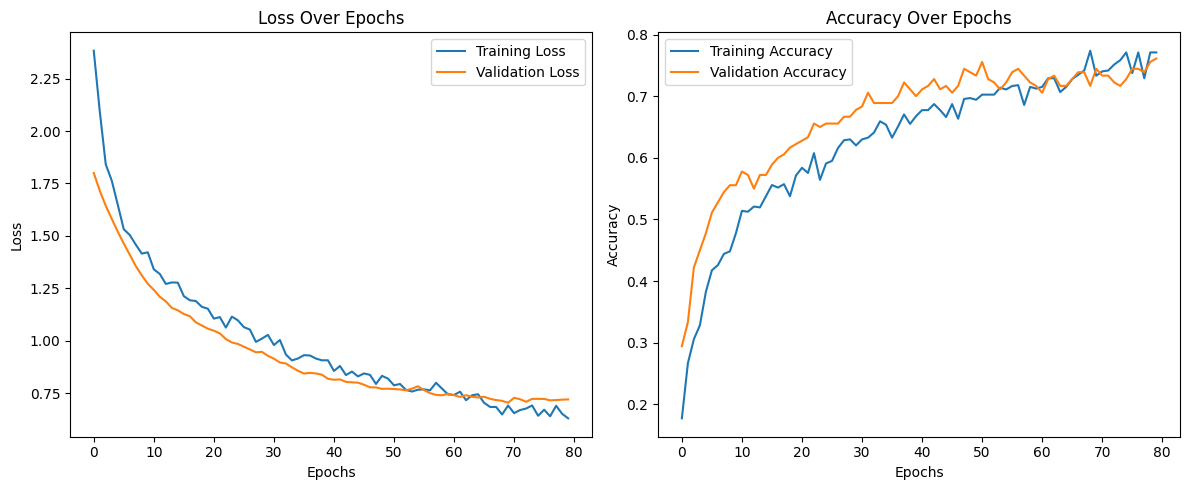

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Improved FCNN Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57        28
           1       0.50      0.57      0.53        21
           2       0.44      0.40      0.42        20
           3       0.92      0.96      0.94        24
           4       0.64      0.62      0.63        26
           5       0.96      0.93      0.95        29
           6       1.00      1.00      1.00        32

    accuracy                           0.74       180
   macro avg       0.72      0.72      0.72       180
weighted avg       0.74      0.74      0.74       180



In [91]:
print("Training Fully Connected Neural Network...")
build_and_train_fcnn(X_train, y_train, X_test, y_test, label_encoder)